## Import data

In [1]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
%cd ..

D:\anomaly-detection


In [6]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [7]:
component = 3
X_one_component = data[str(component)]

In [8]:
train_ratio = 0.6
train_len = int(X_one_component.shape[0] * train_ratio)
X_tr = X_one_component[train_len:]
X_val = X_one_component[train_len:]

In [9]:
from src.features.build_features import rolling_window
window_length = 64

X_tr_windows = rolling_window(pd.DataFrame(X_tr), window_length).squeeze()
X_val_windows = rolling_window(pd.DataFrame(X_val), window_length).squeeze()

## Configs model

In [9]:
from src.models.autoencoder import build_autoencoder
import keras

create_params = dict(
    input_shape=window_length,
    hidden_layer_size=8,
    hidden_layer_activation=None,
    reg_strength=0.001,
    input_dropout=-1,
)

compile_params = dict(
    optimizer=keras.optimizers.Adam(lr=0.001),
)

fit_params = dict(
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5),
               keras.callbacks.EarlyStopping(min_delta=0.01, patience=15)]
)

model_fn = lambda: build_autoencoder(create_params, compile_params)

Using TensorFlow backend.


Lets choose one of components

## Train model

### Cross validation

In [ ]:
# from src.utils import cross_validate

# results = cross_validate(model_fn, 3, fit_params, X_one_component, X_one_component)

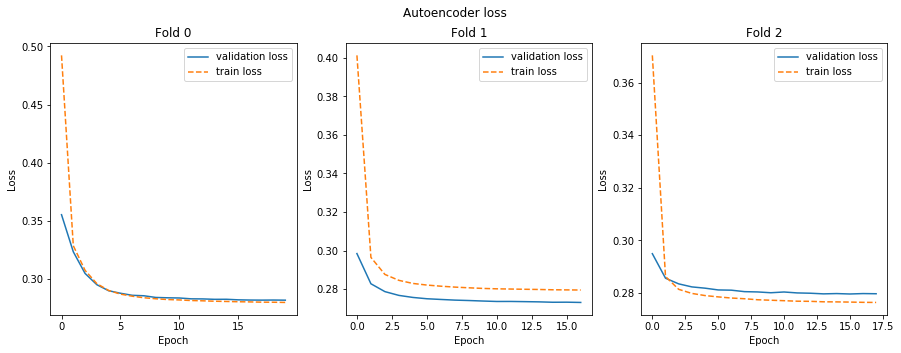

In [14]:
# from src.visualization.visualize import visualize_result
# visualize_result(results, f'Autoencoder loss')

### Train/validation

In [10]:
model = model_fn()
model.fit(
    X_tr_windows,
    X_tr_windows,
    validation_data=(X_val_windows, X_val_windows),
    batch_size=64,
    epochs=100,
    verbose=1,
)







Train on 5057 samples, validate on 5057 samples
Epoch 1/100
5057/5057 [==============================] - 1s 256us/step - loss: 0.6139 - val_loss: 0.4543
Epoch 2/100
5057/5057 [==============================] - 0s 37us/step - loss: 0.3812 - val_loss: 0.3418
Epoch 3/100
5057/5057 [==============================] - 0s 34us/step - loss: 0.3339 - val_loss: 0.3262
Epoch 4/100
5057/5057 [==============================] - 0s 31us/step - loss: 0.3211 - val_loss: 0.3154
Epoch 5/100
5057/5057 [==============================] - 0s 28us/step - loss: 0.3107 - val_loss: 0.3055
Epoch 6/100
5057/5057 [==============================] - 0s 31us/step - loss: 0.3013 - val_loss: 0.2973
Epoch 7/100
5057/5057 [==============================] - 0s 20us/step - loss: 0.2945 - val_loss: 0.2913
Epoch 8/100
5057/5057 [==============================] - 0s 25us/step - loss: 0.2897 - val_loss: 0.2878
Epoch 9/100
5057/5057 [==============================] - 0s 22us/step - loss: 0.2868 - val_loss: 0.2858
Epoch 10/

5057/5057 [==============================] - 0s 37us/step - loss: 0.2762 - val_loss: 0.2760
Epoch 69/100
5057/5057 [==============================] - 0s 37us/step - loss: 0.2762 - val_loss: 0.2762
Epoch 70/100
5057/5057 [==============================] - 0s 40us/step - loss: 0.2763 - val_loss: 0.2759
Epoch 71/100
5057/5057 [==============================] - 0s 46us/step - loss: 0.2763 - val_loss: 0.2761
Epoch 72/100
5057/5057 [==============================] - 0s 40us/step - loss: 0.2765 - val_loss: 0.2760
Epoch 73/100
5057/5057 [==============================] - 0s 37us/step - loss: 0.2763 - val_loss: 0.2760
Epoch 74/100
5057/5057 [==============================] - 0s 34us/step - loss: 0.2760 - val_loss: 0.2762
Epoch 75/100
5057/5057 [==============================] - 0s 34us/step - loss: 0.2766 - val_loss: 0.2759
Epoch 76/100
5057/5057 [==============================] - 0s 37us/step - loss: 0.2763 - val_loss: 0.2758
Epoch 77/100
5057/5057 [==============================] - 0s 31us/st

In [13]:
model.save('models/onedimensional_autoencoder.h5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
Total params: 1,096
Trainable params: 1,096
Non-trainable params: 0
_________________________________________________________________


## Extract first layer that can embedes data

In [15]:
import keras
from keras.layers import Input
from keras.models import Model, load_model

model = load_model('models/onedimensional_autoencoder.h5')

Using TensorFlow backend.


In [16]:
inp = Input(shape=(window_length,))
encoder_layer = model.layers[0]
encoded = encoder_layer(inp)

encoder = Model(inputs=inp, outputs=encoded)

## Adding anomalies

In [13]:
from src.data.generate import generate_anomalies
data_with_anom = data[str(component)].copy()
anom_amount = 100
anom_idxs_start = np.random.choice(len(data_with_anom),
                                   anom_amount,
                                   replace=False)
anom_lens = np.zeros(anom_amount, dtype=int)
anom_idxs = np.zeros(len(data_with_anom), dtype=int)

for i, idx in enumerate(anom_idxs_start):
    l = np.random.randint(window_length, window_length * 2)

    if idx + l > data_with_anom.shape[0]:
        raise Exception('Try again, index out of range (FIXME THEN)')

    anom_lens[i] = l
    anoms = generate_anomalies(l)
    anom_idxs[idx:idx + l] = 1
    data_with_anom[idx:idx + l] = anoms[np.random.randint(len(anoms))]

In [14]:
X_anom = rolling_window(pd.DataFrame(data_with_anom), window_length).squeeze()

## Clustering

### KMeans

In [18]:
encoded = encoder.predict(X_anom)

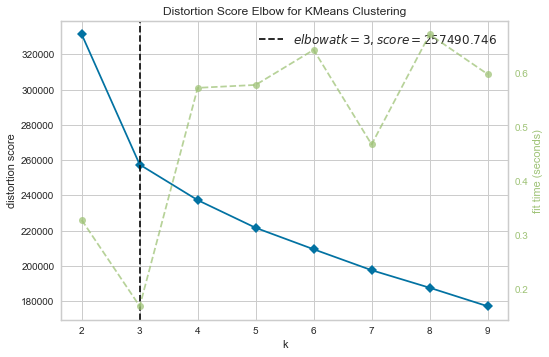

In [20]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,10), metric='distortion')
visualizer.fit(encoded)
visualizer.poof()

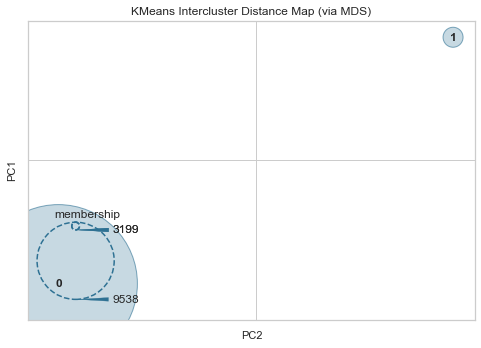

In [28]:
from yellowbrick.cluster import InterclusterDistance

km = KMeans(2)
intra_visualizer = InterclusterDistance(km)

intra_visualizer.fit(encoded)        # Fit the data to the visualizer
intra_visualizer.poof()        # Draw/show/poof the data

In [29]:
pred = km.predict(encoded)
minimal_cluster = pd.Series(pred).value_counts().idxmin()
anoms_pred = np.where(pred == minimal_cluster)[0]

In [26]:
import src.utils
import importlib
importlib.reload(src.utils)

<module 'src.utils' from 'D:\\anomaly-detection\\src\\utils.py'>

In [30]:
from bokeh.plotting import figure, show
from src.utils import *

p = figure(plot_width=800,
           plot_height=600,
           tools="xwheel_zoom,pan,box_zoom,reset")

# Green - all data
# Red - anomalies generated
# Blue - model predicted as anomaly

recall = intersection_over_true(data_with_anom.shape[0], anom_idxs_start, anom_lens, anoms_pred, window_length)

p.multi_line(
    [
        list(range(data_with_anom.shape[0])),
        *[list(range(idx, idx + l)) for idx, l in zip(anom_idxs_start, anom_lens)],
        *[list(range(idx, idx + window_length)) for idx in anoms_pred],
    ],
    [
        data_with_anom,
        *[
            data_with_anom.iloc[idx:idx + l]
            for idx, l in zip(anom_idxs_start, anom_lens)
        ],
        *[data_with_anom.iloc[idx:idx + window_length] for idx in anoms_pred],
    ],
    color=["green", *['red'] * len(anom_idxs_start), *['blue'] * len(anoms_pred)],
    alpha=[0.6, *[0.5] * len(anom_idxs_start), *[0.5] * len(anoms_pred)],
    line_width=4,
    legend=f'Recall score: {recall:.2f}',
)

show(p)